In [16]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import pandas as pd
import csv
from sklearn.utils import shuffle
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Roderick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Roderick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
'''NOTES:
THIS SCRIPT RANDOMELY SPLITS THE DATASET INTO 70% TRAINING,
15% Valid, 15% Test

Change the values as needed to change training params

It is then saved into the RawData Folder as a csv. Simply
Import the csv using pandas from_csv() function to recreate
the dataframes. 

Have fun, boys. 
'''

wnl = WordNetLemmatizer()
stopW = set(stopwords.words('english'))
totalData = []

with open('SMSSpamCollection.txt', newline = '') as csvfile:
    spamreader = csv.reader(csvfile, quotechar='|')
    for row in spamreader:
        totalData.append(row[0])
        
labels = []
values = []
for row in totalData:
    try:
        row.split()[1]
        labels.append(row.split()[0]) 
        #ans = " ".join(row.split()[1:]) #lower casing text and lemmatize
        ans = row.split()[1:]
        #word_tokens = word_tokenize(ans)
        filtered_ans = [wnl.lemmatize(w) for w in ans if not w.lower() in stopW]
        filtered_ans = " ".join(filtered_ans)
        values.append(filtered_ans)
    except:
        print("opp got em chief") #do not add data without a label/value match. some only have a label
        
print(len(values), len(labels))
totalData = list(zip(labels, values))
print(totalData[:10])

totalData = pd.DataFrame(totalData)

df = shuffle(totalData)

print(totalData.head)
testData= df.iloc[int(len(df)*0.85):, :] #15%
validData = df.iloc[int(len(df)*0.7):int(len(df)*0.85), :]#15%
trainData = df.iloc[:int(len(df)*0.7), :]#70%

print(testData.shape, validData.shape, trainData.shape)
current_directory = os.getcwd()
testData.to_csv(os.path.join(current_directory, 'testData.csv'), header=None)
validData.to_csv(os.path.join(current_directory, 'validData.csv'), header=None)
trainData.to_csv(os.path.join(current_directory, 'trainData.csv'), header=None)

opp got em chief
opp got em chief
opp got em chief
opp got em chief
5570 5570
[('ham', 'Go jurong point'), ('ham', 'Ok lar... Joking wif u oni...'), ('spam', "Free entry 2 wkly comp win FA Cup final tkts 21st May 2005. Text FA 87121 receive entry question(std txt rate)T&C's apply 08452810075over18's"), ('ham', 'U dun say early hor... U c already say...'), ('ham', 'Nah think go usf'), ('spam', "FreeMsg Hey darling 3 week's word back! I'd like fun still? Tb ok! XxX std chgs send"), ('ham', 'Even brother like speak me. treat like aid patent.'), ('ham', "per request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' set callertune Callers. Press *9 copy friend Callertune"), ('spam', 'WINNER!! valued network customer selected receivea Â£900 prize reward! claim call 09061701461. Claim code KL341. Valid 12 hour only.'), ('spam', 'mobile 11 month more? U R entitled Update latest colour mobile camera Free! Call Mobile Update Co FREE 08002986030')]
<bound method NDFrame.head of          0       

In [3]:
train_data = pd.read_csv('trainData.csv', header=None)
train_data[2].fillna("", inplace=True)
train_data.iloc[:, 1] = train_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
train_data[1].astype(int)

0       0
1       0
2       0
3       0
4       0
       ..
3893    0
3894    0
3895    0
3896    0
3897    0
Name: 1, Length: 3898, dtype: int32

In [4]:
valid_data = pd.read_csv('validData.csv', header=None)
valid_data[2].fillna("", inplace=True)
valid_data.iloc[:, 1] = valid_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
valid_data[1].astype(int)

0      0
1      0
2      0
3      0
4      0
      ..
831    0
832    0
833    0
834    0
835    0
Name: 1, Length: 836, dtype: int32

In [5]:
test_data = pd.read_csv('testData.csv', header=None)
test_data[2].fillna("", inplace=True)
test_data.iloc[:, 1] = test_data.iloc[:, 1].astype(str).map({'ham': 0, 'spam': 1}).astype(int)
test_data[1].astype(int)

0      0
1      0
2      0
3      0
4      1
      ..
831    1
832    0
833    0
834    0
835    0
Name: 1, Length: 836, dtype: int32

In [6]:
print(train_data[1].value_counts())
print(valid_data[1].value_counts())
print(test_data[1].value_counts())

print(519/(519+3379))
print(110/(110+726))
print(118/(118+718))
#we can see that the dataset is imbalanced where spam is only ~13% of the dataset.

1
0    3363
1     535
Name: count, dtype: int64
1
0    725
1    111
Name: count, dtype: int64
1
0    735
1    101
Name: count, dtype: int64
0.1331452026680349
0.13157894736842105
0.14114832535885166


# Tf-idf Vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data[2])
y_train = train_data[1].astype(int)

X_valid = tfidf_vectorizer.transform(valid_data[2])
y_valid = valid_data[1].astype(int)

X_test = tfidf_vectorizer.transform(test_data[2])
y_test = test_data[1].astype(int)

train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.001,0.01,0.1,1,10,100,1000,10000]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

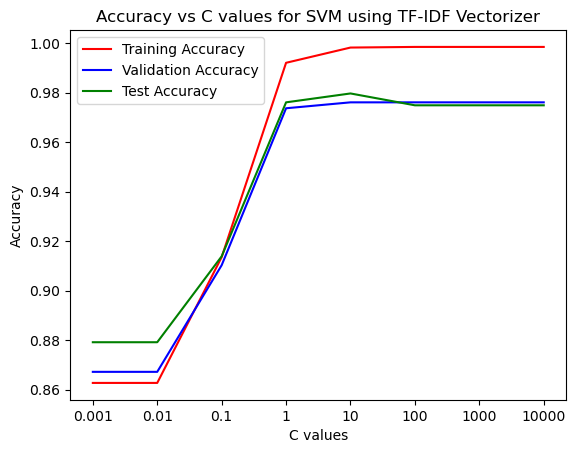

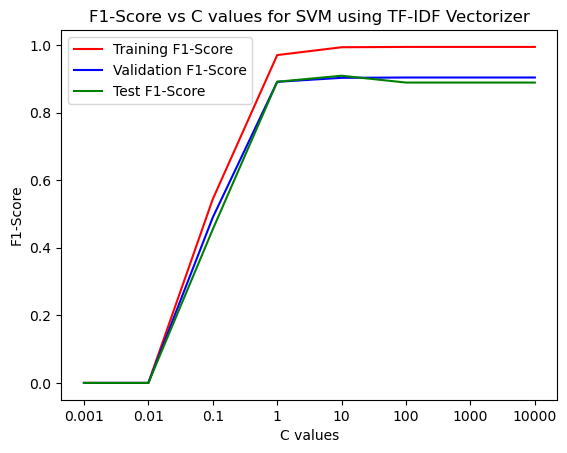

In [29]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

In [34]:
train_accuracy = []
train_f1 = []
validation_accuracy = []
validation_f1 = []
test_accuracy = []
test_f1 = []

C_values = [0.01,0.05,0.1,0.3,0.5,0.7,0.9,1]
for c in C_values:
    base_model = SVC(C=c,kernel="linear")
    base_model.fit(X_train,y_train)
    
    y_pred_train = base_model.predict(X_train)
    y_pred_valid = base_model.predict(X_valid)
    y_pred_test = base_model.predict(X_test)
    
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    train_f1.append(f1_score(y_train, y_pred_train))
    
    validation_accuracy.append(accuracy_score(y_valid, y_pred_valid))
    validation_f1.append(f1_score(y_valid, y_pred_valid))
    
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    test_f1.append(f1_score(y_test, y_pred_test))

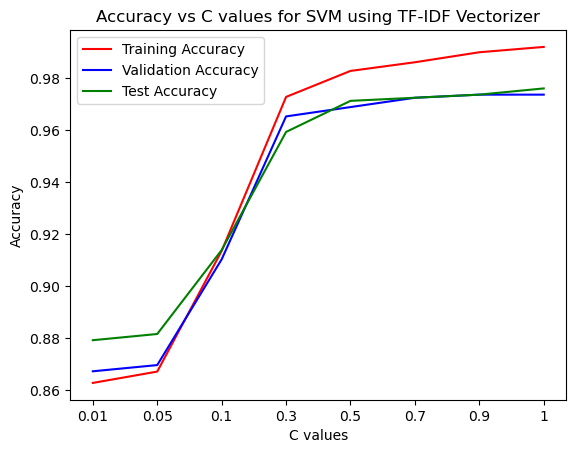

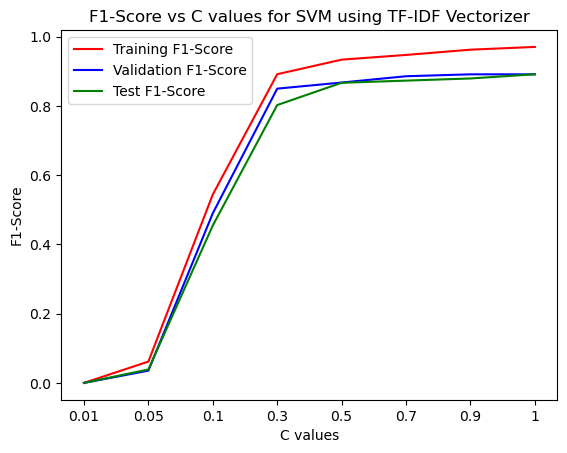

In [35]:
index = list(range(len(C_values)))

plt.plot(index, train_accuracy, linestyle='-', color='r', label='Training Accuracy')
plt.plot(index, validation_accuracy, linestyle='-', color='b', label='Validation Accuracy')  
plt.plot(index, test_accuracy, linestyle='-', color='g', label='Test Accuracy')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()

plt.plot(index, train_f1, linestyle='-', color='r', label='Training F1-Score')
plt.plot(index, validation_f1, linestyle='-', color='b', label='Validation F1-Score')  
plt.plot(index, test_f1, linestyle='-', color='g', label='Test F1-Score')
plt.xticks(index, C_values)
plt.xlabel('C values')
plt.ylabel('F1-Score')
plt.title('F1-Score vs C values for SVM using TF-IDF Vectorizer')
plt.legend()

plt.show()